# Spotify Podcast Dataset - Reading Transcripts

Attempt to come up with an API to support batch processing of transcripts for this data set.

In [9]:
import pandas as pd
import os
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
from collections import Counter
plt.rcParams['figure.figsize'] = [5, 5]


In [10]:
df = pd.read_csv('../podcasts-no-audio-13GB-selected/metadata.tsv', sep='\t')

In [11]:
basename = '../podcasts-no-audio-13GB-selected/spotify-podcasts-2020/show-rss/'

In [12]:
# Locations of episodes are based on two levels of folders: 
#    first_folder/second_folder/show/episode_metadata.json
# To figure out the first_folder and second_folder by looking at 
# the first two characters in the show_uri column.

# Then you can extract the transcripts...

df['first_dir'] = df['show_uri'].str.extract(r'spotify:show:(\w)')[0]
df['second_dir'] = df['show_uri'].str.extract(r'spotify:show:\w(\w)')[0]

## Attempt to extract the RSS category metadata of a show.

Find all the categories in "4G" folder

In [13]:
import xml.etree.ElementTree as ET

def find_category(file): 
    extracted_data = []
    
    # Parse the XML file
    tree = ET.parse(file)
    root = tree.getroot()
    
    # Iterate through the XML elements
    for element in root.iter():
        # Check if the element name contains "category"
        if 'category' in element.tag:
            # Check if the element has a "text" attribute
            if 'text' in element.attrib:
                # Extract and store the data from the "text" attribute
                text_data = element.attrib['text']
                extracted_data.append(text_data)
    
    return extracted_data

In [14]:
df['show_filename_prefix'].dropna().unique().shape

(18376,)

In [15]:
files_found_counter = 0
categories = []
category_tuple_list = []
# Iterate through files in the folder and its subdirectories
for root, dirs, files in os.walk(basename):
    for filename in files:
        # Check if the file is a JSON file
        if filename.endswith('.xml'):
            # TODO / ISSUE: there are two more xml files found based on the 
            # metadata file's number of possible shows.
            # TODO / ISSUE: there are 8 errors in valid show RSS files.
            try:
                files_found_counter += 1
                file_path = os.path.join(root, filename)
                cats = find_category(file_path)
                categories.extend(cats)
                for cat in cats: 
                    category_tuple_list.append((filename[:-4], cat))
            except:
                print(f"Error in file: {filename}")
print(files_found_counter)
print(len(set(categories)))

Error in file: show_0mPNCwVSQ8ggY3Wo3a4RPy.xml
Error in file: show_0mmkBlmEqlEWzMeLGWy4Wy.xml
Error in file: show_0deezmILkTBDuYDKucY5mx.xml
Error in file: show_0KbQ39FLDGiQkEq1WMcqjV.xml
Error in file: show_6zSmRhYdSy1f2yXIZFRlBE.xml
Error in file: show_4HQGW7WAjn5QB8F8gd8jE9.xml
Error in file: show_3LKjtl2pOvhqsp6GnoGkWi.xml
Error in file: show_5h1lw7E7efT5r9LeOkPA7b.xml
18379
122


In [16]:
category_tuple_list[:5]

[('show_0RpgmiJjAk5DHxzABcllYp', 'Leisure'),
 ('show_0RpgmiJjAk5DHxzABcllYp', 'Games'),
 ('show_0ruY06AVqTtXm1Rs3bwDtZ', 'Society & Culture'),
 ('show_0r4ElWjFWBJRuzH6ooMBvK', 'Sports'),
 ('show_0r4ElWjFWBJRuzH6ooMBvK', 'Basketball')]

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Comedy'),
  Text(1, 0, 'Education'),
  Text(2, 0, 'Sports'),
  Text(3, 0, 'Health & Fitness'),
  Text(4, 0, 'Business')])

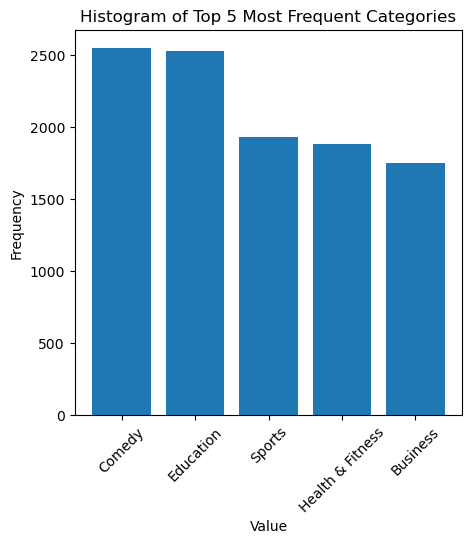

In [17]:
category_counts = Counter(categories)
sorted_counts = dict(sorted(category_counts.items(), key=lambda item: item[1], reverse=True)[:5])
top_5_values, frequencies = zip(*sorted_counts.items())
plt.bar(top_5_values, frequencies)
# Add labels and title
plt.xlabel('Value');
plt.ylabel('Frequency');
plt.title('Histogram of Top 5 Most Frequent Categories');
plt.xticks(rotation=45)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Professional'),
  Text(1, 0, 'Podcasting'),
  Text(2, 0, 'College & High School'),
  Text(3, 0, 'Physics'),
  Text(4, 0, 'Management & Marketing')])

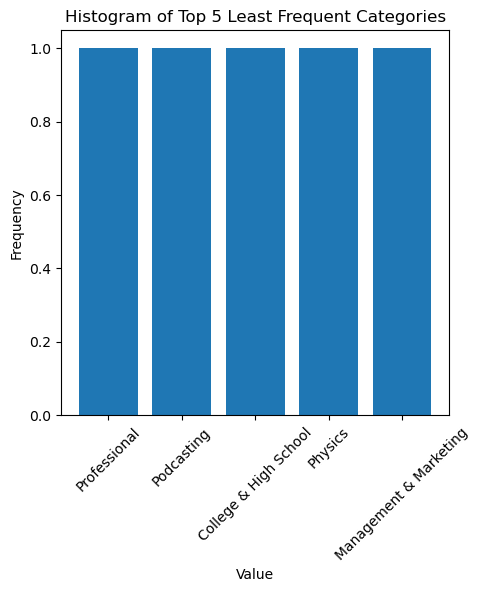

In [18]:
category_counts = Counter(categories)
sorted_counts = dict(sorted(category_counts.items(), key=lambda item: item[1], reverse=True)[-5:])
bottom_5_values, frequencies = zip(*sorted_counts.items())
plt.bar(bottom_5_values, frequencies)
# Add labels and title
plt.xlabel('Value');
plt.ylabel('Frequency');
plt.title('Histogram of Top 5 Least Frequent Categories');
plt.xticks(rotation=45)


In [19]:
# Create a DataFrame from the list of tuples
cats_df = pd.DataFrame(category_tuple_list, columns=['show_filename_prefix', 'category'])
print(cats_df.shape)
cats_df.head(2)

(27021, 2)


,show_filename_prefix,category
0,show_0RpgmiJjAk5DHxzABcllYp,Leisure
1,show_0RpgmiJjAk5DHxzABcllYp,Games


In [20]:
duration_df = df[['show_filename_prefix','duration']].groupby('show_filename_prefix').mean()
duration_df = duration_df.reset_index()
duration_df['mean_show_duration'] = duration_df['duration']
duration_df = duration_df.drop(columns=['duration'])
duration_df.head(2)


,show_filename_prefix,mean_show_duration
0,show_002B8PbILr169CdsS9ySTH,57.177200
1,show_005ZAjJK1wlD4E2YxeibBb,82.179683


In [21]:
bottom_5_values

('Professional',
 'Podcasting',
 'College & High School',
 'Physics',
 'Management & Marketing')

In [22]:
cats_df = cats_df.merge(duration_df, on='show_filename_prefix', how='left')
cats_df['top_5'] = cats_df['category'].isin(top_5_values)
cats_df['bottom_5'] = cats_df['category'].isin(bottom_5_values)
print(cats_df.shape)
cats_df.head(10)

(27021, 5)


,show_filename_prefix,category,mean_show_duration,top_5,bottom_5
0,show_0RpgmiJjAk5DHxzABcllYp,Leisure,74.605217,False,False
1,show_0RpgmiJjAk5DHxzABcllYp,Games,74.605217,False,False
2,show_0ruY06AVqTtXm1Rs3bwDtZ,Society & Culture,50.707967,False,False
3,show_0r4ElWjFWBJRuzH6ooMBvK,Sports,30.467283,True,False
4,show_0r4ElWjFWBJRuzH6ooMBvK,Basketball,30.467283,False,False
5,show_0R4GSy1q25PM6mttQ3c5Qy,Education,34.256267,True,False
6,show_0R4GSy1q25PM6mttQ3c5Qy,Language Learning,34.256267,False,False
7,show_0rHf8IEnXNN1w59Uzk4HDF,Religion & Spirituality,23.618567,False,False
8,show_0ruZQJg9LwzLbOQIfsN8W8,Leisure,39.077633,False,False
9,show_0ruZQJg9LwzLbOQIfsN8W8,Automotive,39.077633,False,False


<Axes: ylabel='Frequency'>

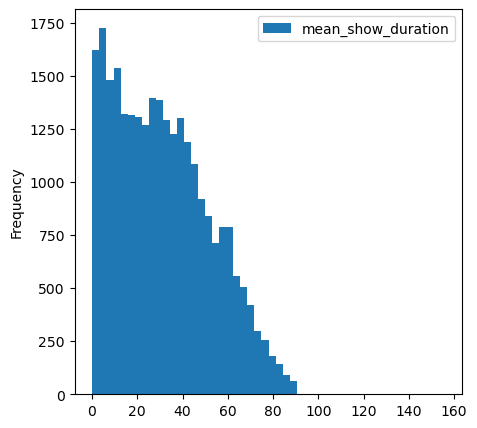

In [23]:
cats_df.plot.hist(y='mean_show_duration',bins=50)

(27021, 5)
(10630, 6)


<Axes: xlabel='category'>

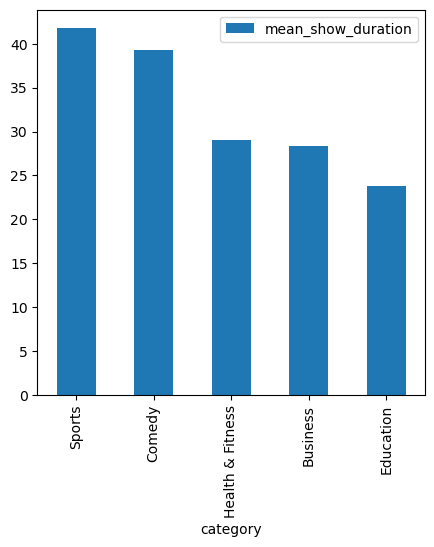

In [24]:
print(cats_df.shape)
new_df = cats_df[cats_df['top_5']==True].reset_index().drop(columns=['index']).reset_index()
print(new_df.shape)
new_df[['category','mean_show_duration']].groupby('category').mean().sort_values(by='mean_show_duration',ascending=False).plot.bar()

In [25]:
import altair as alt

# Create a scatter plot with category encoded in color
scatter_plot = alt.Chart(new_df.sample(5000)).mark_circle(size=60).encode(
    x=alt.X('index:O', title='Index'),  # 'O' specifies ordinal encoding
    y=alt.Y('mean_show_duration:Q', title='Duration'),
    color=alt.Color('category:N')
)  # Calculate the index as an ordinal field

scatter_plot = scatter_plot.properties(
    width=400,
    height=300,
    title='Scatter Plot of Duration vs. Category'
).configure_title(
    fontSize=16,
    anchor='middle'
)

scatter_plot

alt.Chart(...)

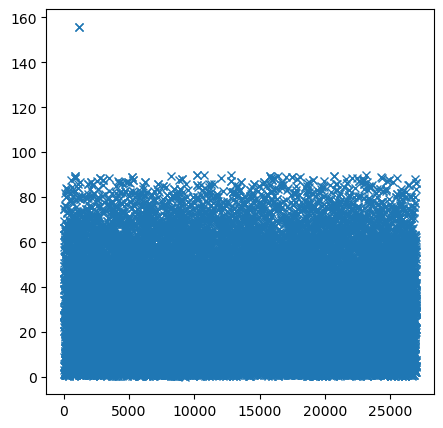

In [26]:
plt.plot(cats_df['mean_show_duration'],'x')

In [27]:
merged_df = df.merge(cats_df, on='show_filename_prefix', how='left')
print(merged_df.shape)
print(merged_df.columns)
merged_df[merged_df['show_filename_prefix']=='show_4Gtc4ccgCF8xySTleFp3HF']

(159438, 18)
Index(['show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix',
       'first_dir', 'second_dir', 'category', 'mean_show_duration', 'top_5',
       'bottom_5'],
      dtype='object')


,show_uri,show_name,show_description,publisher,language,rss_link,episode_uri,episode_name,episode_description,duration,show_filename_prefix,episode_filename_prefix,first_dir,second_dir,category,mean_show_duration,top_5,bottom_5
117284,spotify:show:4Gtc4ccgCF8xySTleFp3HF,Anything and Everything,It’s ya boi Nathan making a podcast where I ch...,Nathan Ortiz,['en'],https://anchor.fm/s/12c31ce0/podcast/rss,spotify:episode:5hsL9wnnzX83q5Qn5XuEMu,Me and my Vietnam war friend Don Vu,"Nathan and Don y’all about wizards, government...",49.663233,show_4Gtc4ccgCF8xySTleFp3HF,5hsL9wnnzX83q5Qn5XuEMu,4,G,Comedy,35.875478,True,False
117285,spotify:show:4Gtc4ccgCF8xySTleFp3HF,Anything and Everything,It’s ya boi Nathan making a podcast where I ch...,Nathan Ortiz,['en'],https://anchor.fm/s/12c31ce0/podcast/rss,spotify:episode:5hsL9wnnzX83q5Qn5XuEMu,Me and my Vietnam war friend Don Vu,"Nathan and Don y’all about wizards, government...",49.663233,show_4Gtc4ccgCF8xySTleFp3HF,5hsL9wnnzX83q5Qn5XuEMu,4,G,Comedy Interviews,35.875478,False,False
127500,spotify:show:4Gtc4ccgCF8xySTleFp3HF,Anything and Everything,It’s ya boi Nathan making a podcast where I ch...,Nathan Ortiz,['en'],https://anchor.fm/s/12c31ce0/podcast/rss,spotify:episode:6Df5bnlC2Ns06W2HK4qJmu,nathan & don talk about ghosts and homeless wo...,just a fun little conversation today with our ...,27.888717,show_4Gtc4ccgCF8xySTleFp3HF,6Df5bnlC2Ns06W2HK4qJmu,4,G,Comedy,35.875478,True,False
127501,spotify:show:4Gtc4ccgCF8xySTleFp3HF,Anything and Everything,It’s ya boi Nathan making a podcast where I ch...,Nathan Ortiz,['en'],https://anchor.fm/s/12c31ce0/podcast/rss,spotify:episode:6Df5bnlC2Ns06W2HK4qJmu,nathan & don talk about ghosts and homeless wo...,just a fun little conversation today with our ...,27.888717,show_4Gtc4ccgCF8xySTleFp3HF,6Df5bnlC2Ns06W2HK4qJmu,4,G,Comedy Interviews,35.875478,False,False
141905,spotify:show:4Gtc4ccgCF8xySTleFp3HF,Anything and Everything,It’s ya boi Nathan making a podcast where I ch...,Nathan Ortiz,['en'],https://anchor.fm/s/12c31ce0/podcast/rss,spotify:episode:6vRd118V8up2pvqsvM4IMF,nathan & don speak about random things w/ a sa...,three friends catch up & dive into some topics...,30.074483,show_4Gtc4ccgCF8xySTleFp3HF,6vRd118V8up2pvqsvM4IMF,4,G,Comedy,35.875478,True,False
141906,spotify:show:4Gtc4ccgCF8xySTleFp3HF,Anything and Everything,It’s ya boi Nathan making a podcast where I ch...,Nathan Ortiz,['en'],https://anchor.fm/s/12c31ce0/podcast/rss,spotify:episode:6vRd118V8up2pvqsvM4IMF,nathan & don speak about random things w/ a sa...,three friends catch up & dive into some topics...,30.074483,show_4Gtc4ccgCF8xySTleFp3HF,6vRd118V8up2pvqsvM4IMF,4,G,Comedy Interviews,35.875478,False,False


In [28]:
# TODO: Why are there 51?  is this the number of episodes in the 
# 8 shows where there were issues finding category?
merged_df['category'].isna().sum()

92

In [29]:
merged_df.head()

,show_uri,show_name,show_description,publisher,language,rss_link,episode_uri,episode_name,episode_description,duration,show_filename_prefix,episode_filename_prefix,first_dir,second_dir,category,mean_show_duration,top_5,bottom_5
0,spotify:show:2NYtxEZyYelR6RMKmjfPLB,Kream in your Koffee,A 20-something blunt female takes on the world...,Katie Houle,['en'],https://anchor.fm/s/11b84b68/podcast/rss,spotify:episode:000A9sRBYdVh66csG2qEdj,1: It’s Christmas Time!,On the first ever episode of Kream in your Kof...,12.700133,show_2NYtxEZyYelR6RMKmjfPLB,000A9sRBYdVh66csG2qEdj,2,N,Leisure,37.729706,False,False
1,spotify:show:15iWCbU7QoO23EndPEO6aN,Morning Cup Of Murder,Ever wonder what murder took place on today in...,Morning Cup Of Murder,['en'],https://anchor.fm/s/b07181c/podcast/rss,spotify:episode:000HP8n3hNIfglT2wSI2cA,The Goleta Postal Facility shootings- January ...,"See something, say something. It’s a mantra ma...",6.019383,show_15iWCbU7QoO23EndPEO6aN,000HP8n3hNIfglT2wSI2cA,1,5,True Crime,7.290034,False,False
2,spotify:show:6vZRgUFTYwbAA79UNCADr4,Inside The 18 : A Podcast for Goalkeepers by G...,Inside the 18 is your source for all things Go...,Inside the 18 GK Media,['en'],https://anchor.fm/s/81a072c/podcast/rss,spotify:episode:001UfOruzkA3Bn1SPjcdfa,Ep.36 - Incorporating a Singular Goalkeeping C...,Today’s episode is a sit down Michael and Omar...,43.616333,show_6vZRgUFTYwbAA79UNCADr4,001UfOruzkA3Bn1SPjcdfa,6,v,Sports,55.862658,True,False
3,spotify:show:6vZRgUFTYwbAA79UNCADr4,Inside The 18 : A Podcast for Goalkeepers by G...,Inside the 18 is your source for all things Go...,Inside the 18 GK Media,['en'],https://anchor.fm/s/81a072c/podcast/rss,spotify:episode:001UfOruzkA3Bn1SPjcdfa,Ep.36 - Incorporating a Singular Goalkeeping C...,Today’s episode is a sit down Michael and Omar...,43.616333,show_6vZRgUFTYwbAA79UNCADr4,001UfOruzkA3Bn1SPjcdfa,6,v,Soccer,55.862658,False,False
4,spotify:show:5BvKEjaMSuvUsGROGi2S7s,Arrowhead Live!,Your favorite podcast for everything @Chiefs! ...,Arrowhead Live!,['en-US'],https://anchor.fm/s/917dba4/podcast/rss,spotify:episode:001i89SvIQgDuuyC53hfBm,Episode 1: Arrowhead Live! Debut,Join us as we take a look at all current Chief...,58.189200,show_5BvKEjaMSuvUsGROGi2S7s,001i89SvIQgDuuyC53hfBm,5,B,Sports,44.145280,True,False


In [30]:
# Save the DataFrame as a TSV file
file_path = '../podcasts-no-audio-13GB-selected/metadata_with_podcast_category.tsv'
merged_df.sample(5000).to_csv(file_path, sep='\t', index=False)

print(f"Merged DataFrame saved as {file_path}")

Merged DataFrame saved as ../podcasts-no-audio-13GB-selected/metadata_with_podcast_category.tsv


In [31]:
new_df = pd.read_csv('../podcasts-no-audio-13GB-selected/metadata_with_podcast_category.tsv', sep='\t')
print(new_df.shape)
print(new_df.columns)

(5000, 18)
Index(['show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix',
       'first_dir', 'second_dir', 'category', 'mean_show_duration', 'top_5',
       'bottom_5'],
      dtype='object')


In [32]:
#TODO: there is an issue where there are more NaNs 
# in the tsv than in the merged_df above.
new_df['cate

SyntaxError: EOL while scanning string literal (50558385.py, line 3)

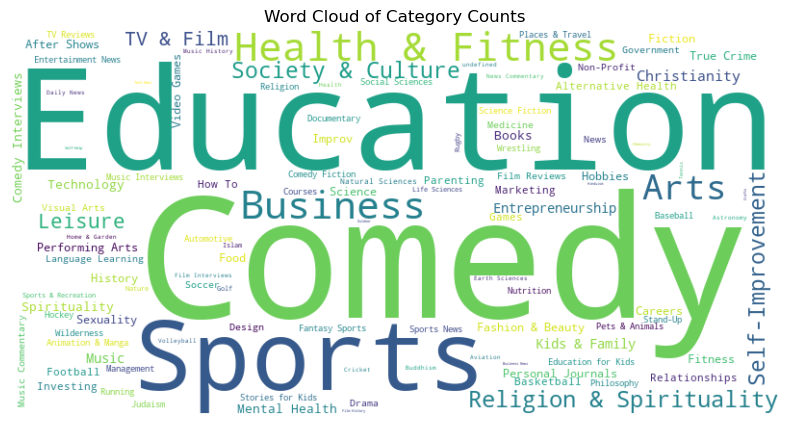

In [36]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sample DataFrame (replace this with your actual data)
data = {
    'Category': ['A', 'B', 'C', 'D', 'E'],
    'Count': [10, 20, 15, 25, 18]
}
df = pd.DataFrame(data)

# Convert the DataFrame to a dictionary
#category_count_dict = dict(zip(df['Category'], df['Count']))

# Specify a TrueType font path
#font_path = '/Users/das/Library/Group Containers/UBF8T346G9.Office/FontCache/4/CloudFonts/Seaford/19722397430.ttf'

# Generate the word cloud with the specified font
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(sorted_counts)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Category Counts')
plt.show()

In [33]:
category_counts = Counter(categories)
sorted_counts = dict(sorted(category_counts.items(), key=lambda item: item[1], reverse=True))
values, frequencies = zip(*sorted_counts.items())

In [34]:
category_count_dict

{'A': 10, 'B': 20, 'C': 15, 'D': 25, 'E': 18}

In [35]:
dict(sorted_counts)

{'Comedy': 2546,
 'Education': 2527,
 'Sports': 1930,
 'Health & Fitness': 1880,
 'Business': 1747,
 'Arts': 1430,
 'Religion & Spirituality': 1369,
 'Society & Culture': 1294,
 'Self-Improvement': 1240,
 'Leisure': 986,
 'TV & Film': 857,
 'Christianity': 463,
 'Kids & Family': 416,
 'Entrepreneurship': 411,
 'Music': 390,
 'Spirituality': 342,
 'Comedy Interviews': 337,
 'Mental Health': 331,
 'Technology': 323,
 'Books': 307,
 'After Shows': 261,
 'Improv': 254,
 'Personal Journals': 234,
 'Science': 216,
 'Video Games': 214,
 'True Crime': 202,
 'Careers': 189,
 'Hobbies': 176,
 'Fiction': 170,
 'Sexuality': 162,
 'Performing Arts': 162,
 'History': 158,
 'Fitness': 154,
 'Food': 150,
 'Fashion & Beauty': 145,
 'Games': 126,
 'Marketing': 124,
 'Alternative Health': 124,
 'Football': 120,
 'Parenting': 116,
 'Relationships': 109,
 'Investing': 108,
 'Basketball': 101,
 'How To': 100,
 'Language Learning': 90,
 'Film Reviews': 87,
 'News': 85,
 'Soccer': 83,
 'Visual Arts': 82,
 'De